# Self-Driving Car Engineer Nanodegree


## Project: **Advanced Lane Finding** 
***

---

#### The goal of this project is to write a software pipeline to identify the lane boundaries in a video.

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
from moviepy.editor import VideoFileClip
%matplotlib inline
# %matplotlib qt

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


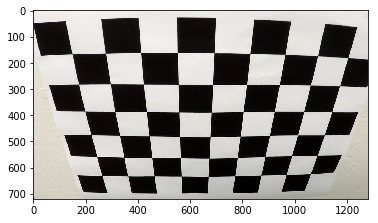

In [2]:
#reading in an image
testimage = mpimg.imread('camera_cal/calibration2.jpg')

#printing out some stats and plotting
print('This image is:', type(testimage), 'with dimensions:', testimage.shape)
plt.imshow(testimage) 

## Camera Calibration

In [3]:
nx = 9
ny = 6
images = glob.glob('camera_cal/calibration*.jpg')

objpoints = []
imgpoints = []
objp = np.zeros((ny * nx, 3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

for fname in images:
    image = mpimg.imread(fname)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    # If found, draw corners
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        
        # Draw and display the corners
        img = cv2.drawChessboardCorners(image, (nx, ny), corners, ret)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)

In [4]:
def plt_img_gray(img1, img2, transformation_text = 'New Image'):
    '''Utility for Plotting Before and After images'''
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img1, cmap='gray')
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(img2, cmap='gray')
    ax2.set_title(transformation_text, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


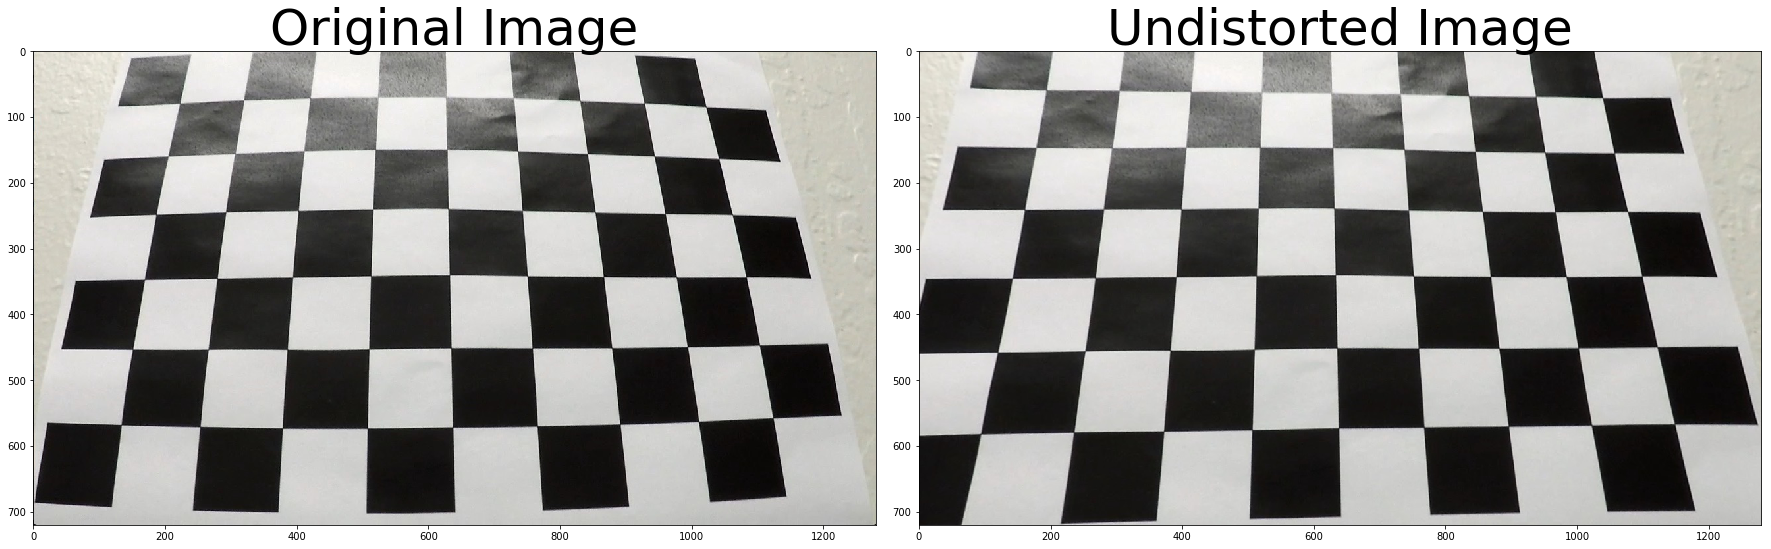

In [5]:
def cal_undistort(img):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    
    return dst

testimage = mpimg.imread('camera_cal/calibration3.jpg')
undst = cal_undistort(testimage)
plt_img_gray(testimage, undst, 'Undistorted Image')

#### Apply Distortion Correction to one of the test imagea

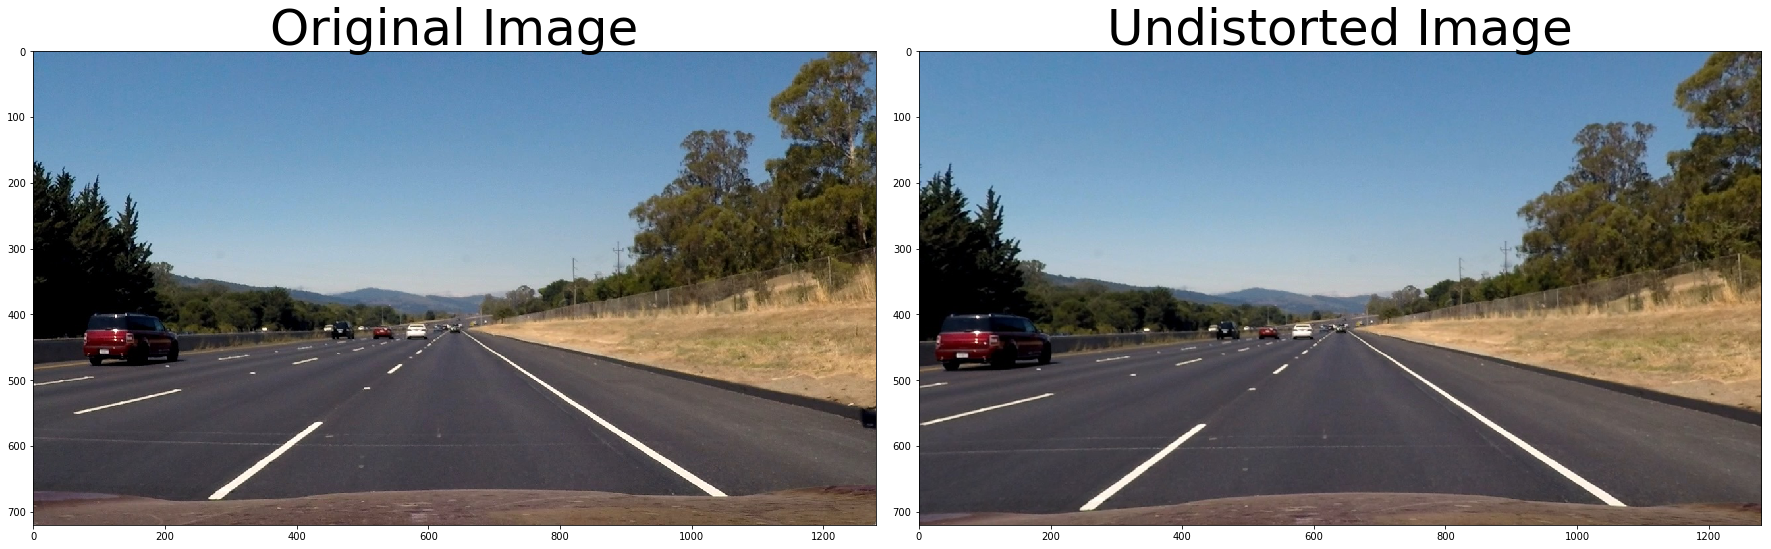

In [6]:

testimage = mpimg.imread('test_images/straight_lines2.jpg')
undst = cal_undistort(testimage)
plt_img_gray(testimage, undst, 'Undistorted Image')

## Colors and Gradient

In [7]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    thresh_min, thresh_max = thresh
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobel = cv2.Sobel(gray, cv2.CV_64F, 1 if orient == 'x' else 0, 0 if orient == 'x' else 1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return sxbinary


def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    thresh_min, thresh_max = mag_thresh
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1 , 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0 , 1, ksize=sobel_kernel)
    mag = np.sqrt(sobelx**2 + sobely**2)
    abs_sobel = np.absolute(mag)
    
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    return sxbinary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    thresh_min, thresh_max = thresh
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1 , 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0 , 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    dir_grad = np.arctan2(abs_sobely, abs_sobelx)

    sxbinary = np.zeros_like(dir_grad)
    sxbinary[(dir_grad >= thresh_min) & (dir_grad <= thresh_max)] = 1

    return sxbinary

def s_channel_threshold(img, thresh=(0, 255)):
    thresh_min, thresh_max = thresh
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= thresh_min) & (s_channel <= thresh_max)] = 1
    
    return s_binary

def r_channel_threshold(img, thresh=(0, 255)):
    thresh_min, thresh_max = thresh
    r_channel = img[:,:,0]

    s_binary = np.zeros_like(r_channel)
    s_binary[(r_channel >= thresh_min) & (r_channel <= thresh_max)] = 1
    
    return s_binary


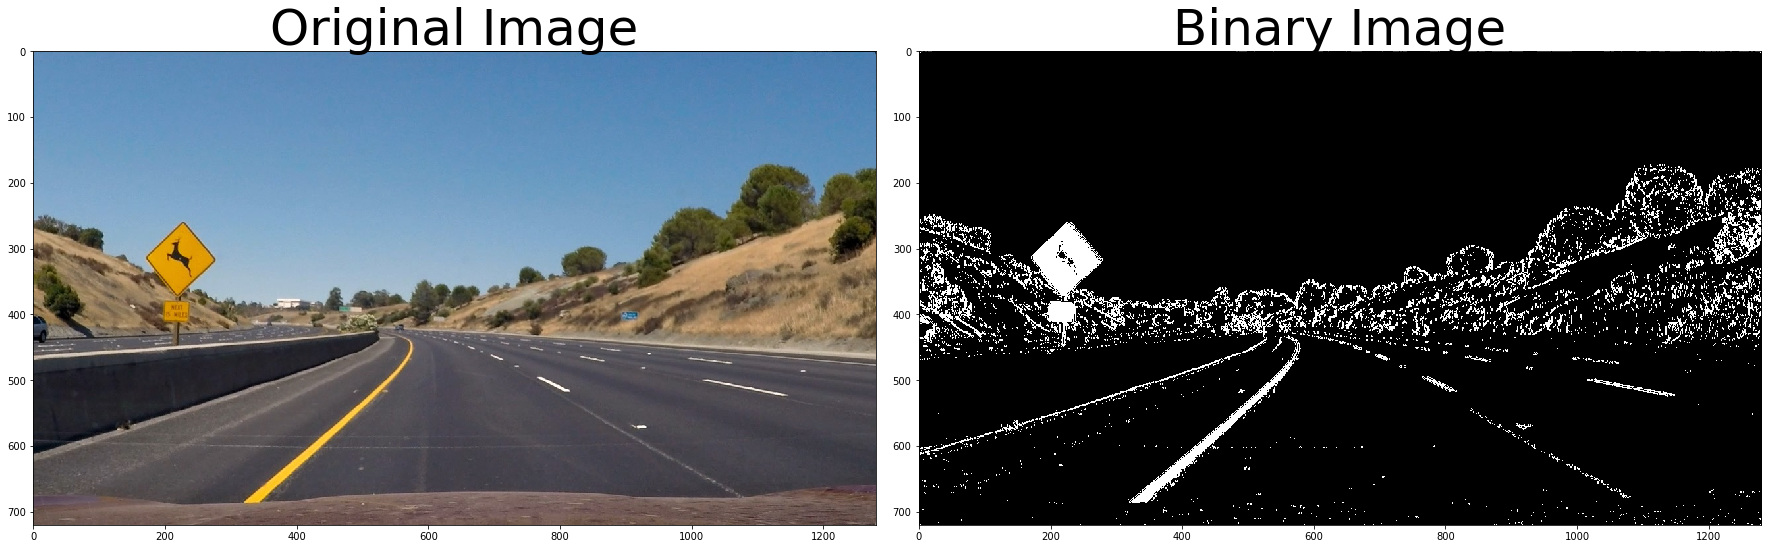

In [8]:
def getBinaryImage(testimage):
    simg = s_channel_threshold(testimage, (180, 255))
    sobel = abs_sobel_thresh(testimage, 'x', 3, (20,100))
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(simg)
    combined_binary[(simg == 1) | (sobel == 1)] = 1

    return combined_binary


testimage = mpimg.imread('test_images/test2.jpg')
binImage = getBinaryImage(testimage)
plt_img_gray(testimage, binImage, "Binary Image")

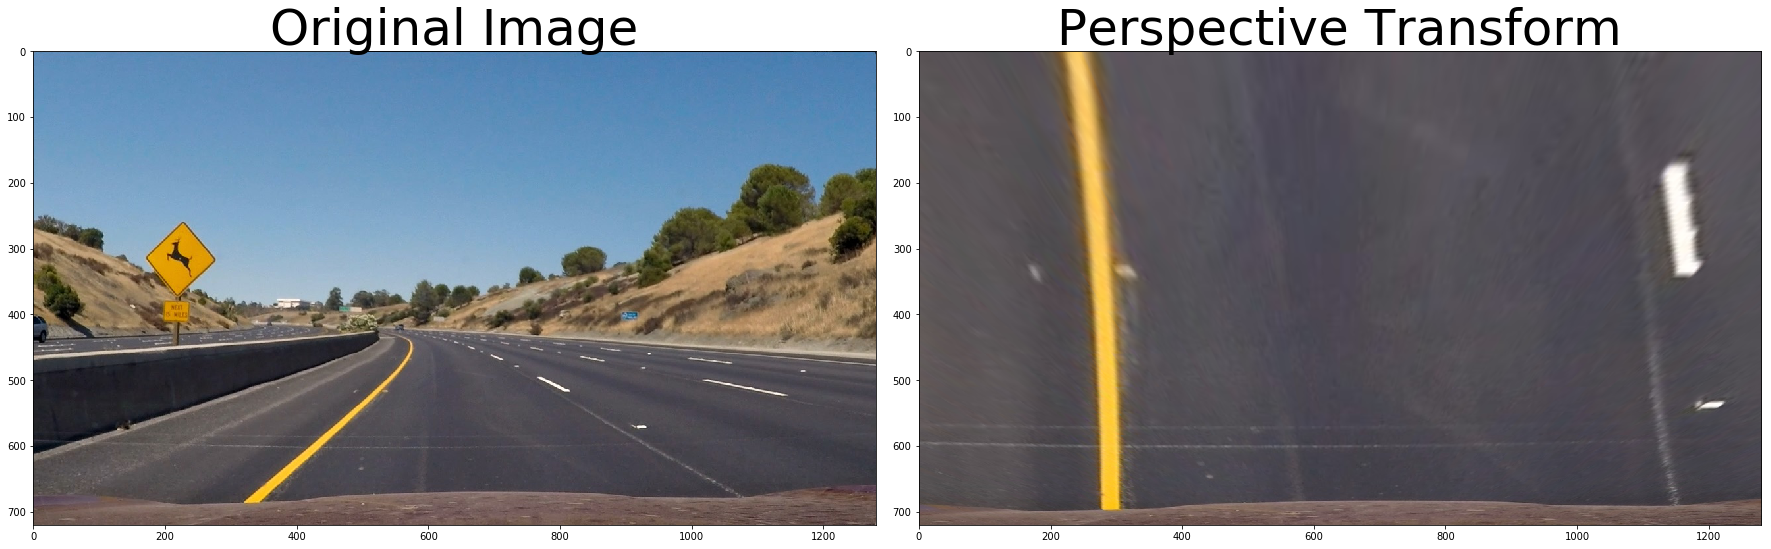

In [9]:
def getPerspectiveTransform():
    # define 4 source points for perspective transformation
    src = np.float32([(190, 720), (548, 480), (740, 480), (1130, 720)])
    # define 4 destination points for perspective transformation
    dst = np.float32([(190, 720), (190, 0), (1130, 0), (1130, 720)])
    # Compute the perspective transform, M,
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    return M, Minv

def getPerspectiveTransformedImage(image):
    imshape = image.shape

    M, Minv = getPerspectiveTransform()
    img_size = (imshape[1], imshape[0])
    warped = cv2.warpPerspective(image, M, img_size)
    
    return warped, M, Minv


testimage = mpimg.imread('test_images/test2.jpg')
transformedImage, M, Minv = getPerspectiveTransformedImage(testimage)
plt_img_gray(testimage, transformedImage, "Perspective Transform")

### Visualize Perspective of Lane Binary Image

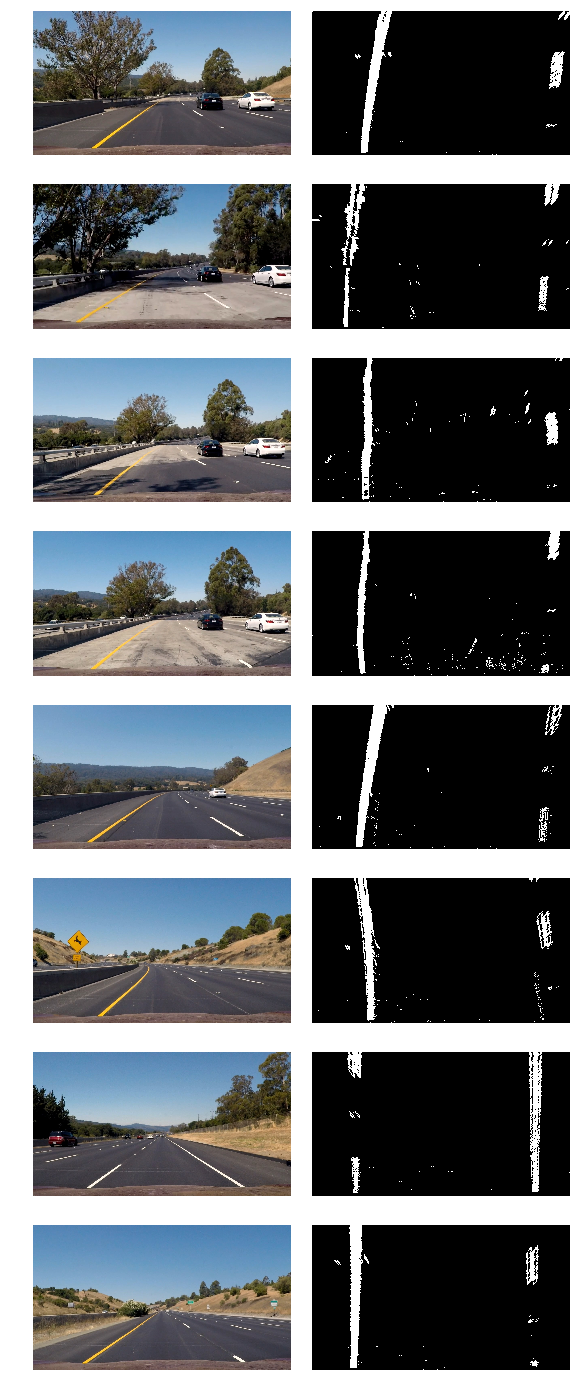

In [10]:
def pipeline(image):
    undistorted_img = cal_undistort(image)
    binaryImage = getBinaryImage(undistorted_img)
    transformedImage, M, Minv = getPerspectiveTransformedImage(binaryImage)
    
    return binaryImage, transformedImage, Minv

## Test Pipeline
images = glob.glob('./test_images/*.jpg')
                                          
# Set up plot
fig, ax = plt.subplots(len(images),2, figsize=(10, 25))
fig.subplots_adjust(hspace = .2, wspace=.001)
ax = ax.ravel()
                  
for i, image in enumerate(images):
    index = i * 2
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_bin, transformImg, Minv = pipeline(img)
    ax[index].imshow(img)
    ax[index].axis('off')

    ax[index + 1].imshow(transformImg, cmap='gray')
    ax[index + 1].axis('off')

(720, 0)

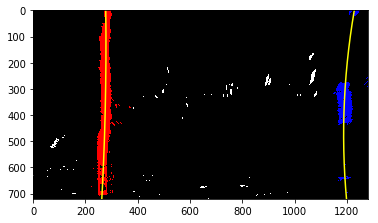

In [11]:
def slidingWindowSearch(binary_warped):

    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    rectangle_data = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        rectangle_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    
    return left_lane_inds, right_lane_inds, histogram, rectangle_data


margin = 100
testimage2 = mpimg.imread('test_images/test4.jpg')
binImage, binary_warped, Minv = pipeline(testimage2) 
# plt_img_gray(binary_warped2, transformImg)
left_lane_inds, right_lane_inds, histogram, rectangles = slidingWindowSearch(binary_warped)
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [12]:
# Define a class to receive the characteristics of each line detection
IMAGE_MAX_Y = 719
class Line():
    def __init__(self, n_frames=1, detected_x=None, detected_y=None):
        self.n_frames = n_frames     # Number of previous frames used to smooth the current frame
        self.best_fit = None         # Polynomial coefficients averaged over the last n_frames frames
        self.current_fit = None      # Polynomial coefficients for the most recent frame
        self.current_fit_poly = None # Polynomial for the current frame's polynomial coefficients
        self.best_fit_poly = None    # Polynomial for the average coefficients over the last n_frames iterations
        self.allx = None             # x values for detected line pixels
        self.ally = None             #
        
    def update(self, x, y):
        self.allx = x
        self.ally = y

        # Fit a polynomial and smooth it using previous frames
        self.current_fit = np.polyfit(self.ally, self.allx, 2)
        if self.best_fit is None:
            self.best_fit = self.current_fit
        else:
            self.best_fit = (self.best_fit * (self.n_frames - 1) + self.current_fit) / self.n_frames

        self.current_fit_poly = np.poly1d(self.current_fit)
        self.best_fit_poly = np.poly1d(self.best_fit)
        
    def distance_between_lines(self, other_line):
        '''Calculate the distance between the currently fitted polynomials of two lines'''
        return np.abs(self.current_fit_poly(IMAGE_MAX_Y) - other_line.current_fit_poly(IMAGE_MAX_Y))
        

In [13]:
img_size = (1280, 720)
def draw_lane(undist, warped, left_fitx, right_fitx, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (warped.shape[1], warped.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

def radius_of_curvature(leftx, rightx):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    ploty = np.linspace(0, 719, num=720)
    y_eval = np.max(ploty)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curve_rad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curve_rad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    # compute the offset from the center
    lane_center = (leftx[719] + rightx[719])/2
    center_offset_pixels = abs(img_size[0]/2 - lane_center)
    center_offset_mtrs = xm_per_pix*center_offset_pixels

    return left_curve_rad, right_curve_rad, center_offset_mtrs


def draw_data_on_lane_image(lane_image, curve_radius, center_distance, binImg, transformedImg):
    new_img = np.copy(lane_image)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(curve_radius) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_distance > 0:
        direction = 'right'
    elif center_distance < 0:
        direction = 'left'
    abs_center_dist = abs(center_distance)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img

MIN_POINTS_REQUIRED = 3
DIST_ALLOWANCE = (800, 1000)
def line_sanity_check(left, right):
    '''Determines if detected lane lines are plausible lines based on the distance between the lines'''
    if len(left[0]) < MIN_POINTS_REQUIRED or len(right[0]) < MIN_POINTS_REQUIRED:
        return False
    else:
        new_left = Line()
        new_left.update(left[0], left[1])
        new_right = Line()
        new_right.update(right[0], right[1])
        
        distance = new_left.distance_between_lines(new_right)
        return DIST_ALLOWANCE[0] < distance < DIST_ALLOWANCE[1]
    

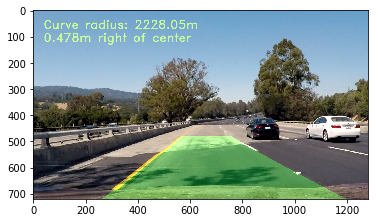

In [14]:
def process_image_final(img, l_lane, r_lane):
    new_img = np.copy(img)

    transformedImg, binary_warped3, Minv = pipeline(new_img)
    left_lane_inds, right_lane_inds, histogram, rectangles = slidingWindowSearch(binary_warped3)
    
    nonzero = binary_warped3.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    is_sane = line_sanity_check((leftx, lefty), (rightx, righty))
    if is_sane:
        if leftx.any():
            if l_lane is None:
                l_lane = Line()
            l_lane.update(y = lefty, x = leftx)

        if rightx.any():
            if r_lane is None:
                r_lane = Line()
            r_lane.update(y = righty, x = rightx)
    
    # Fit a second order polynomial to each
#     left_fit = np.polyfit(lefty, leftx, 2)
#     right_fit = np.polyfit(righty, rightx, 2)
    left_fit = l_lane.best_fit
    right_fit = r_lane.best_fit


    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped3, binary_warped3, binary_warped3))*255

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped3.shape[0]-1, binary_warped3.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    lane_image = draw_lane(img, binary_warped3, left_fitx, right_fitx, Minv)
    rad_left, rad_right, d_center  = radius_of_curvature (left_fitx, right_fitx)
    average_curve_rad = (rad_left + rad_right) / 2
    annotated_image = draw_data_on_lane_image(lane_image, average_curve_rad, d_center, binary_warped3, transformedImg)
    return annotated_image

testimage5 = mpimg.imread('test_images/test4.jpg')
l_lane = None
r_lane = None
te = process_image_final(testimage5, l_lane, r_lane)
plt.imshow(te)

In [15]:
fl_line = Line()
fr_line = Line()

video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')#.subclip(22,26)
processed_video = video_input1.fl_image(lambda image: process_image_final(image, fl_line, fr_line))
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output-5.mp4
[MoviePy] Writing video project_video_output-5.mp4


100%|█████████▉| 1260/1261 [02:37<00:00,  8.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output-5.mp4 

CPU times: user 3min 58s, sys: 29.7 s, total: 4min 28s
Wall time: 2min 38s
